In [1]:
import pandas as pd
import datascience as ds
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

Load in the California Housing Data 

In [2]:

    from sklearn.datasets import fetch_california_housing
    # Load Scikit-Learn's housing dataset
    housing = fetch_california_housing(as_frame=True)

# Load the dataset into Pandas data frame
df = pd.DataFrame(housing.data, columns=housing.feature_names) # Dataset features
df["MedHouseVal"] = housing.target # Response

# Load the dataset into Datascience table
housing_table = ds.Table.from_df(df)
housing_table.show(10)

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
8.3252,41,6.98413,1.02381,322,2.55556,37.88,-122.23,4.526
8.3014,21,6.23814,0.97188,2401,2.10984,37.86,-122.22,3.585
7.2574,52,8.28814,1.07345,496,2.80226,37.85,-122.24,3.521
5.6431,52,5.81735,1.07306,558,2.54795,37.85,-122.25,3.413
3.8462,52,6.28185,1.08108,565,2.18147,37.85,-122.25,3.422
4.0368,52,4.76166,1.10363,413,2.1399,37.85,-122.25,2.697
3.6591,52,4.93191,0.951362,1094,2.1284,37.84,-122.25,2.992
3.12,52,4.79753,1.06182,1157,1.78825,37.84,-122.25,2.414
2.0804,42,4.29412,1.11765,1206,2.02689,37.84,-122.26,2.267
3.6912,52,4.97059,0.990196,1551,2.17227,37.84,-122.25,2.611


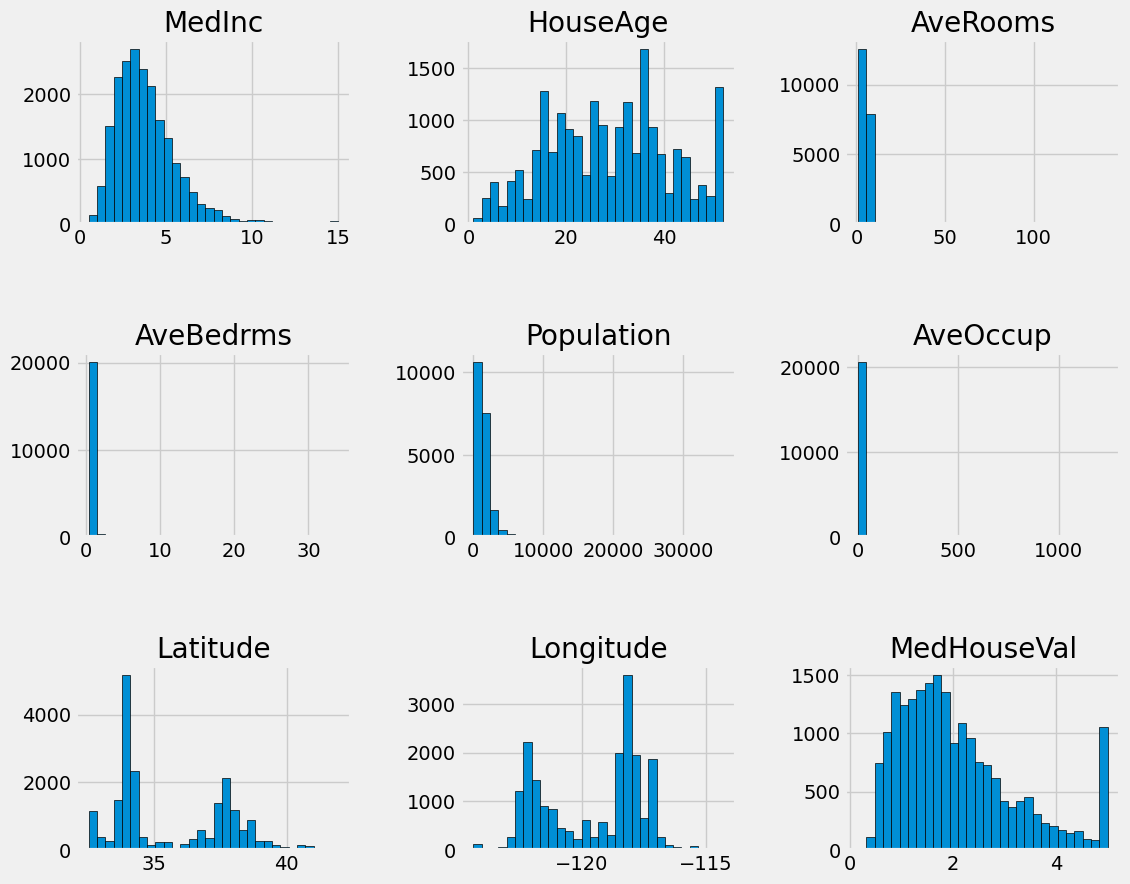

In [7]:
housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.savefig("data_dist.png", dpi=100)

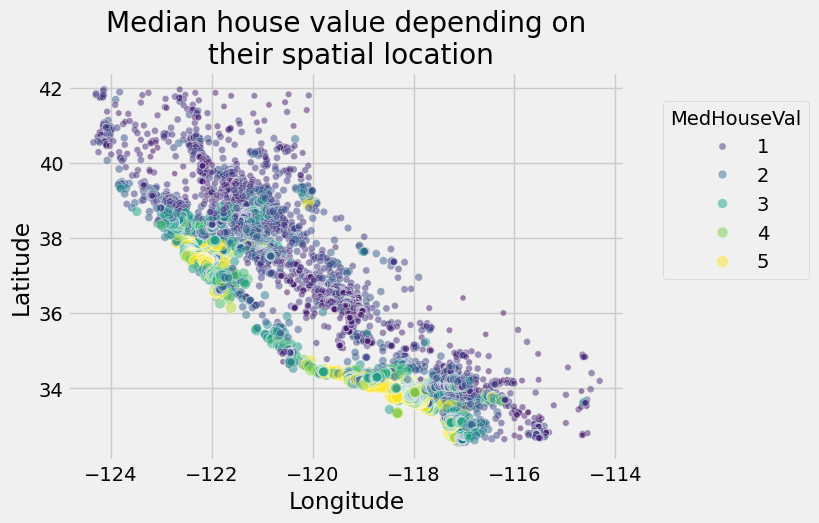

In [8]:
import seaborn as sns

sns.scatterplot(
    data=housing.frame,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending on\n their spatial location")
#plt.savefig("SpatialLocation.png", dpi=200)

Split the data into training and testing

In [11]:
# Set seed to get consistent results
seed = 100

# Predictors
X = df.drop("MedHouseVal", axis=1)
# Response - Median House Value
Y = df["MedHouseVal"]

In [12]:
from sklearn.model_selection import train_test_split
# test_size=0.2 - 20% of data is used for testing and not training
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

from sklearn.model_selection import cross_val_score

# Train the model on different maximum depths (distance from root node to the leaf nodes)
# Try different max_depths (1 - 20)
for depth in np.arange(1, 21, 1):
    model = DecisionTreeRegressor(max_depth=depth, random_state=seed)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    test_mse = mean_squared_error(y_test, y_pred)
    train_mse = mean_squared_error(y_train, model.predict(x_train))
    score = np.mean(cross_val_score(model, X, Y, cv=5, scoring='r2'))
    print(f"Depth: {depth}, R²: {r2_score(y_test, y_pred):.4f}, CV Score: {score}, Test MSE: {test_mse:.4f}, Train MSE: {train_mse:.4f}")

# No maximum depth specified
model = DecisionTreeRegressor(random_state=seed)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred)
train_mse = mean_squared_error(y_train, model.predict(x_train))
print(f"Depth: {model.get_depth()}, R²: {r2_score(y_test, y_pred):.4f}, Test MSE: {test_mse:.4f}, Train MSE: {train_mse:.4f}")

Depth: 1, R²: 0.3105, CV Score: 0.23674794744539876, Test MSE: 0.9290, Train MSE: 0.9167
Depth: 2, R²: 0.4578, CV Score: 0.38376233007491806, Test MSE: 0.7306, Train MSE: 0.7383
Depth: 3, R²: 0.5365, CV Score: 0.4479999369802784, Test MSE: 0.6245, Train MSE: 0.6226
Depth: 4, R²: 0.5841, CV Score: 0.4735781496183657, Test MSE: 0.5604, Train MSE: 0.5546
Depth: 5, R²: 0.6316, CV Score: 0.46140641222621015, Test MSE: 0.4964, Train MSE: 0.4840
Depth: 6, R²: 0.6677, CV Score: 0.47769729442303993, Test MSE: 0.4478, Train MSE: 0.4183
Depth: 7, R²: 0.6871, CV Score: 0.5130611539014197, Test MSE: 0.4217, Train MSE: 0.3641
Depth: 8, R²: 0.7118, CV Score: 0.5081686560743272, Test MSE: 0.3883, Train MSE: 0.3080
Depth: 9, R²: 0.7156, CV Score: 0.5017661979316774, Test MSE: 0.3832, Train MSE: 0.2609
Depth: 10, R²: 0.7018, CV Score: 0.48621231964657274, Test MSE: 0.4018, Train MSE: 0.2146
Depth: 11, R²: 0.6960, CV Score: 0.4545214413080993, Test MSE: 0.4096, Train MSE: 0.1684
Depth: 12, R²: 0.6896, CV

Train model

In [6]:
model = DecisionTreeRegressor(max_depth=9, random_state=seed)
model.fit(x_train, y_train)
model.get_n_leaves()

428

In [10]:
pred_y = model.predict(X)
pred_y


array([ 4.74916643,  3.71970706,  3.85378261, ...,  0.85944055,
        0.73623077,  0.85944055])

In [5]:
train_r2 = r2_score(y_train, model.predict(x_train))
test_r2  = r2_score(y_test,  model.predict(x_test))
print(train_r2, test_r2)

1.0 0.6431553949707887


Plot Decision Tree

In [44]:
plt.figure(figsize=(50, 25))
plot_tree(
    model,
    feature_names=housing.feature_names,
    filled=True,
    rounded=True,
    fontsize=6
)
plt.title("Decision Tree Structure")
plt.savefig("decision_tree.png", dpi=200)
plt.close()

Look at Feature Importance

In [ ]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(14, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.savefig("feature_importance.png", dpi=100)
plt.show()

importance_df

In [ ]:
for feature in X.columns:
    sorted_idx = X[feature].argsort()
    x_vals = X[feature].values[sorted_idx]
    y_vals = Y.values[sorted_idx]

    X_line = pd.DataFrame(np.tile(X.mean().values, (len(x_vals), 1)), columns=X.columns)
    X_line[feature] = x_vals

    y_line = model.predict(X_line)

    plt.figure(figsize=(8, 5))
    plt.scatter(x_vals, y_vals, alpha=0.3, label="Actual", color="gray")
    plt.plot(x_vals, y_line, color="red", linewidth=2, label="Model Prediction")
    plt.xlabel(feature)
    plt.ylabel("Median House Value")
    plt.title(f"{feature} vs. Median House Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

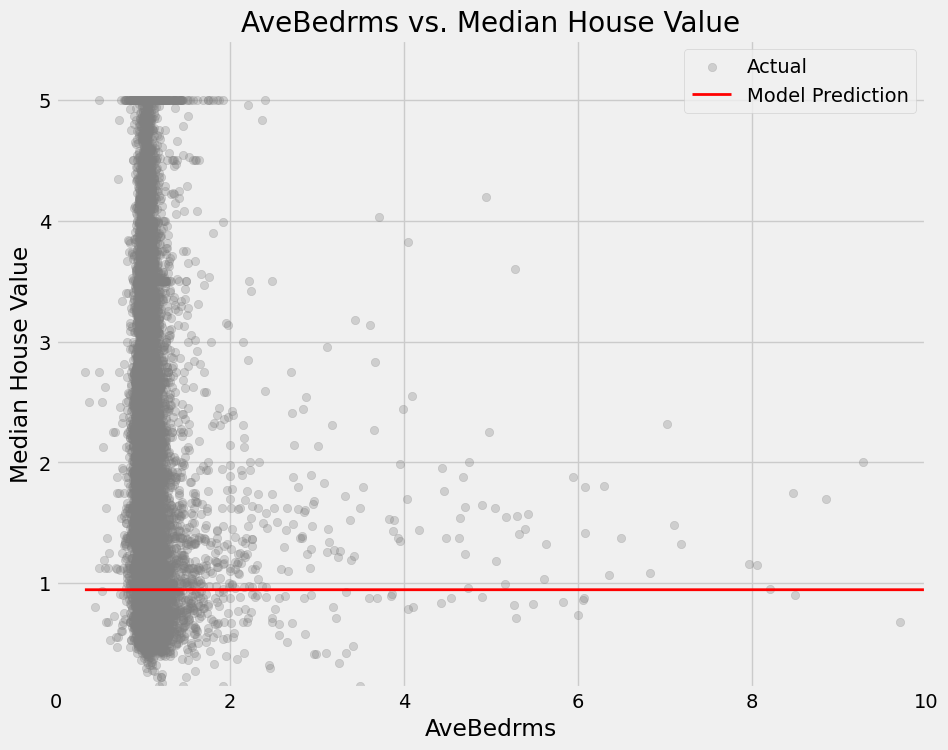

In [84]:
feature = "AveBedrms"
sorted_idx = X[feature].argsort()
x_vals = X[feature].values[sorted_idx]
y_vals = Y.values[sorted_idx]
X_line = pd.DataFrame(np.tile(X.mean().values, (len(x_vals), 1)), columns=X.columns)
X_line[feature] = x_vals

y_line = model.predict(X_line)

plt.figure(figsize=(10, 8))
plt.scatter(x_vals, y_vals, alpha=0.3, label="Actual", color="gray")
plt.plot(x_vals, y_line, color="red", linewidth=2, label="Model Prediction")
plt.xlabel(feature)
plt.ylabel("Median House Value")
plt.ylim(bottom=min(y_vals) * 0.9, top=max(y_vals) * 1.1)
plt.xlim(left=0, right=10)
plt.title(f"{feature} vs. Median House Value")
plt.legend()
plt.savefig(f"{feature}vsMedHouseVal.png", dpi=100)
plt.show()

Feature Correlation Matrix

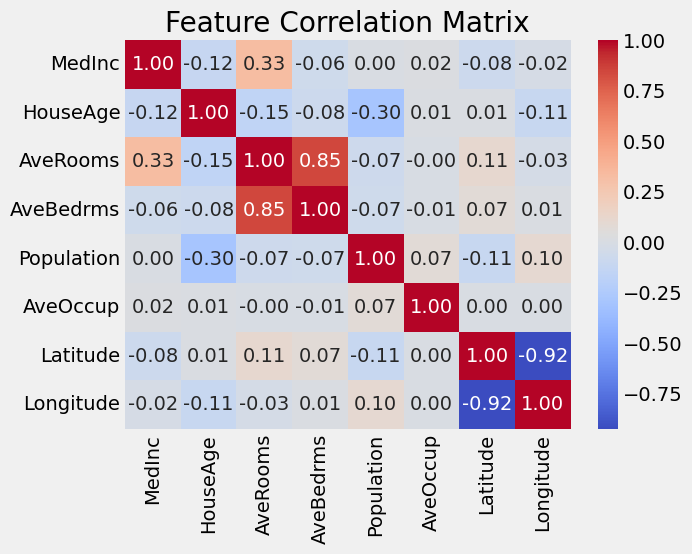

In [41]:
import seaborn as sns

corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

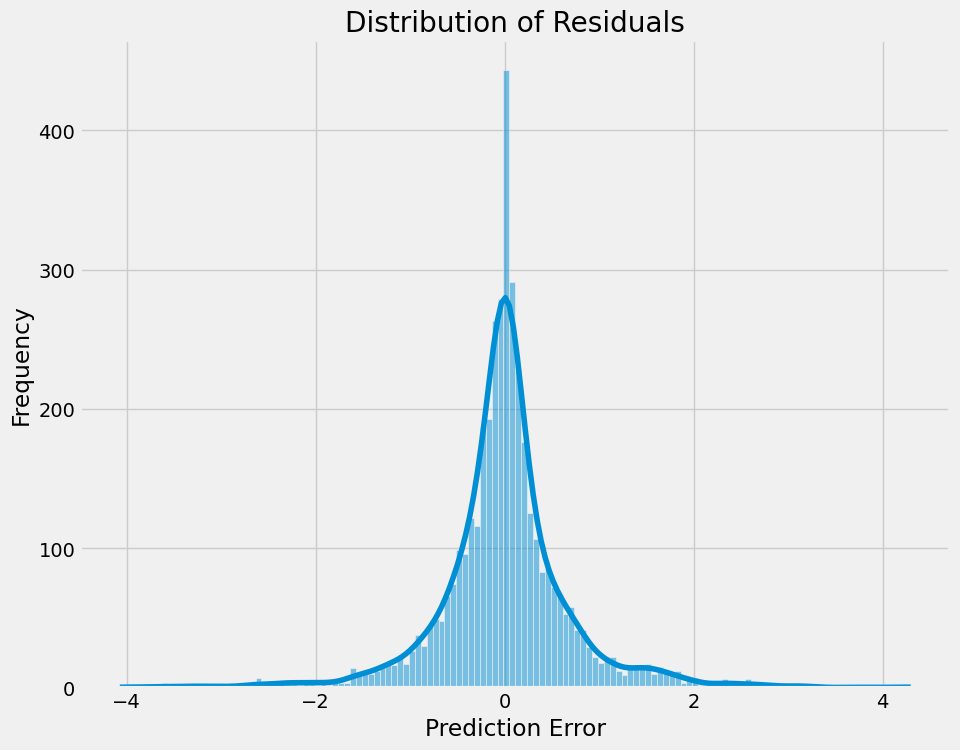

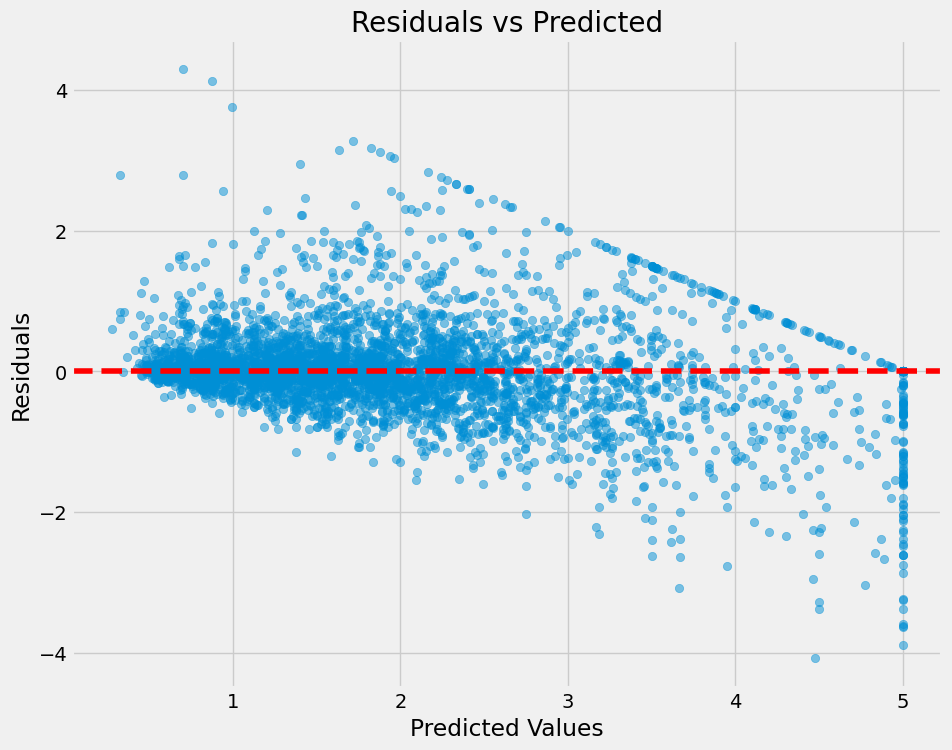

In [88]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 8))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.savefig("DistResiduals.png", dpi=200)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.savefig("ResidualsVsPredicted.png", dpi=200)
plt.show()

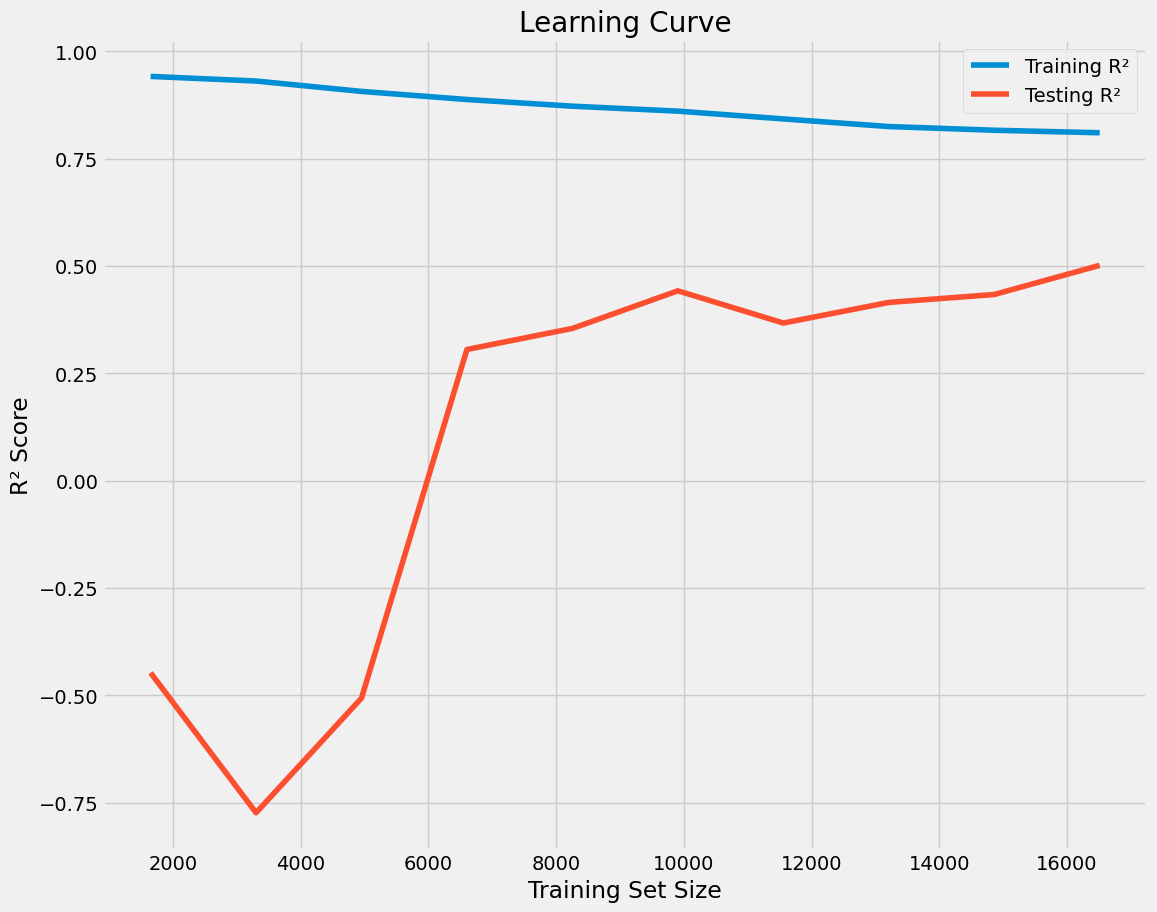

In [12]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    DecisionTreeRegressor(max_depth=9, random_state=seed),
    X, Y,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(12, 10))
plt.plot(train_sizes, train_mean, label='Training R²')
plt.plot(train_sizes, val_mean,   label='Testing R²')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.savefig("LearningCurve.png")
plt.show()

Pruning

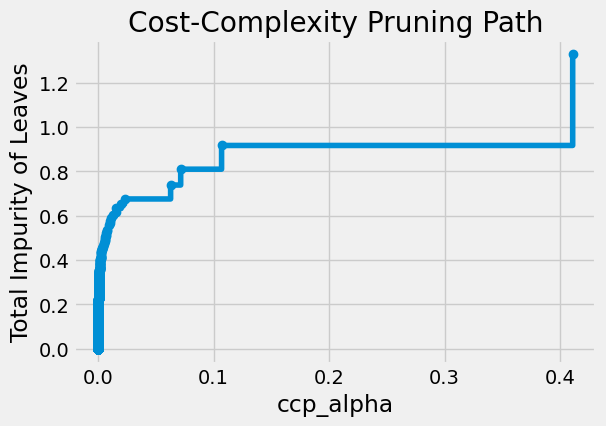

In [6]:
# 1) Fit an unconstrained tree
base_model = DecisionTreeRegressor(random_state=seed)
base_model.fit(x_train, y_train)

# 2) Compute the effective alphas and corresponding total leaf impurities
path = base_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# 3) Plot impurity vs alpha
plt.figure(figsize=(6,4))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
plt.xlabel("ccp_alpha")
plt.ylabel("Total Impurity of Leaves")
plt.title("Cost-Complexity Pruning Path")
plt.show()

In [7]:
from sklearn.model_selection import GridSearchCV

# Build a small grid over the promising alpha values
alphas_to_try = ccp_alphas[np.linspace(0, len(ccp_alphas)-1, 10, dtype=int)]

param_grid = {'ccp_alpha': alphas_to_try}
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=seed),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(x_train, y_train)

best_alpha = grid.best_params_['ccp_alpha']
print("Best ccp_alpha:", best_alpha)
print("CV MSE:", -grid.best_score_)

# Refit pruned tree
pruned_model = DecisionTreeRegressor(random_state=seed, ccp_alpha=best_alpha)
pruned_model.fit(x_train, y_train)
print("Test MSE:", mean_squared_error(y_test, pruned_model.predict(x_test)))
print("Test R²:", r2_score(y_test, pruned_model.predict(x_test)))

Best ccp_alpha: 3.27519379845e-05
CV MSE: 0.510359453174
Test MSE: 0.44778980888135705
Test R²: 0.6676631135834463


In [9]:
new_y_pred = pruned_model.predict(x_test)
print(f"R2: {r2_score(y_test, new_y_pred)}")

R2: 0.6676631135834463
